# From FHIR to ML: Getting Started with the PHC Python SDK

To get started, we simply import the relevant libraries and select our project:

In [1]:
# Install release from (09-27-2021)
!pip install --upgrade phc==0.23.2

In [2]:
# Import phc library
import phc.easy as phc

from pandas.api.types import CategoricalDtype
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Many data frames have numerous columns
pd.set_option("display.max_columns", 100)

SEED = 1337

/opt/conda/lib/python3.9/site-packages/phc/easy/util/__init__.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Select the demo BRCA project
phc.Project.set_current("BRCA")

,id,name,genomeBuild,description,owner,part11,auditLogging,versioning,lrn,mrnConfig,account,shortName
98,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,BRCA Research,GRCh38,"TCGA BRCA dataset of 1,097 breast cancer patie...",NaN,NaN,False,False,lrn:lo:us:demo:project:34c0fb25-bbde-4eb1-87ed...,"{'configType': 'typeCoding', 'system': 'http:/...",demo,NaN


In [4]:
# This is our shared authentication object (assumed by default)
auth = phc.Auth.shared()

# Showing the project id is selected
auth.project_id

'34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013'

## Exploration

We'll begin by exploring the FHIR codes for the conditions of the patients in this data set.

In [5]:
carcinoma_codes = phc.Condition.get_codes("carcinoma")
carcinoma_codes.head()

0it [00:00, ?it/s]

,code,code_count,display,patient_count,system
1,82711006,778,"Infiltrating duct carcinoma, NOS",778,http://snomed.info/sct
2,89740008,201,"Lobular carcinoma, NOS",201,http://snomed.info/sct
3,35232005,28,Infiltrating duct and lobular carcinoma,28,http://snomed.info/sct
4,128700001,19,Infiltr. duct mixed with other types of carcinoma,19,http://snomed.info/sct
5,72495009,16,Mucinous adenocarcinoma,16,http://snomed.info/sct


For this example, let's check out this first code and see if there's anything interesting in the data.

In [6]:
condition_initial_df = phc.Condition.get_data_frame(
    display="Infiltrating duct carcinoma, NOS",
    all_results=True
)

condition_initial_df.head()

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading data frame from "/home/jovyan/Downloads/phc/api-cache/fhir_dsl_condition_where_507f36f0.csv"


,id,code.coding_system__snomed.info/sct__code,code.coding_system__snomed.info/sct__display,code.coding_system__snomed.info/sct__code_1,resourceType,onsetDateTime.tz,onsetDateTime.local,bodySite.coding_system__snomed.info/sct__code,bodySite.coding_system__snomed.info/sct__display,subject.reference,stage.summary_coding_system__snomed.info/sct__code,stage.summary_coding_system__snomed.info/sct__display,meta.tag_system__lifeomic.com/fhir/dataset__code
0,002c238a-f029-4ed9-a605-02d4cdb84b8b,82711006,"Infiltrating duct carcinoma, NOS",254837009,Condition,0.0,1998-01-01 00:00:00+00:00,735083009,Part of left breast,Patient/d4e7426c-9739-4585-9114-e564b13c7c02,13104003.0,Clinical stage I (finding),34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013
1,01523b5b-2f8d-4f1d-9055-a2cbd0b6bd5f,82711006,"Infiltrating duct carcinoma, NOS",254837009,Condition,0.0,2010-01-01 00:00:00+00:00,110494001,Upper inner quadrant of right breast,Patient/cf0e7e4e-b857-4db5-9ae2-551a899f77be,50283003.0,Clinical stage III (finding),34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013
2,05310e42-5986-4648-8244-fa3d429cb27c,82711006,"Infiltrating duct carcinoma, NOS",254837009,Condition,0.0,2008-01-01 00:00:00+00:00,110496004,Upper outer quadrant of right breast,Patient/cab38ea8-4555-413c-b81e-4621aac4ef85,13104003.0,Clinical stage I (finding),34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013
3,06107cca-6fbe-4f51-800d-ed4cb80f9503,82711006,"Infiltrating duct carcinoma, NOS",254837009,Condition,0.0,1994-01-01 00:00:00+00:00,735083009,Part of left breast,Patient/34ab0cb8-bf19-4cbb-b4eb-3c45ee5aa60b,60333009.0,Clinical stage II (finding),34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013
4,0653c2de-f1ef-4a59-806f-19cb40f718e2,82711006,"Infiltrating duct carcinoma, NOS",254837009,Condition,0.0,2008-01-01 00:00:00+00:00,110501003,Upper outer quadrant of left breast,Patient/1d27253f-b036-44e7-a04d-8da5bbf57419,50283003.0,Clinical stage III (finding),34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013


It looks there are various recorded stages of infiltrating duct carcinoma in the dataset. Keep in mind that records are timestamp based so we can easily have a person with multiple recorded stages as the disease progresses.

In [7]:
condition_initial_df["stage.summary_coding_system__snomed.info/sct__display"].value_counts()

Clinical stage II (finding)     450
Clinical stage III (finding)    154
Clinical stage I (finding)      140
Clinical stage IV (finding)      16
Name: stage.summary_coding_system__snomed.info/sct__display, dtype: int64

From here, we can simplify the data frame and focus on the final recorded stage for each patient.

In [8]:
stage_df = (
    condition_initial_df
    # Make these columns a little less verbose
    .rename(columns={
        "stage.summary_coding_system__snomed.info/sct__display": "stage",
        "subject.reference": "patient_id",
        "onsetDateTime.local": "date"
    })
    # Pipe allows us to do an arbitrary transform and the result will be passed
    # to the next transform
    .pipe(
        # Assign allows assigned/re-assigning columns to the frame immutably
        lambda df: df.assign(
            # Replace prefix indicating resource since this references patient
            patient_id=df["patient_id"].str.replace("Patient/", ""),
            # Convert onset to date since time data does not exist
            date=df["date"].dt.date,
            stage=df["stage"].astype(
                CategoricalDtype(categories=[
                    'Clinical stage I (finding)',
                    'Clinical stage II (finding)',
                    'Clinical stage III (finding)',
                    'Clinical stage IV (finding)'
                ], ordered=True)
            )
        )
    )
    # Narrow frame down to two columns
    [["patient_id", "date", "stage"]]
    # Get the latest record by date
    .sort_values("date", ascending=False).groupby("patient_id").first()
    # Ensure stage value exists
    .pipe(
        lambda df: df[df["stage"].notnull()]
    )
)

stage_df.head()

,date,stage
patient_id,,
001cef41-ff86-4d3f-a140-a647ac4b10a1,2010-01-01,Clinical stage I (finding)
00a2d166-78c9-4687-a195-3d6315c27574,2010-01-01,Clinical stage II (finding)
01263518-5f7c-49dc-8d7e-84b0c03a6a63,2009-01-01,Clinical stage IV (finding)
0130d616-885e-4a6c-9d03-2f17dd692a05,2010-01-01,Clinical stage II (finding)
01674b2c-5cf2-478f-84a1-f69c39f47bd4,2009-01-01,Clinical stage II (finding)


Because we have decent number of these records (760), let's use this as the target feature for a predictive model. We'll assemble a list of some example features across Patient and Observation, and employ a simple Random Forest classifier as the predictive model.

## Developing Predictive Features

Moving on from these disease stage records, let's grab the Patient data to and make sure these Condition records are actually associated with patients.

In [9]:
patient_intial_df = phc.Patient.get_data_frame(
    ids=stage_df.index,
    all_results=True
)

patient_intial_df.head()

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading data frame from "/home/jovyan/Downloads/phc/api-cache/fhir_dsl_patient_where_609c8da8.csv"


,id,name_given_0,name_family,extension.url__hl7.org/fhir/StructureDefinition/us-core-race__valueCodeableConcept_text,extension.url__hl7.org/fhir/StructureDefinition/us-core-race__valueCodeableConcept_coding_system__hl7.org/fhir/v3/Race__code,extension.url__hl7.org/fhir/StructureDefinition/us-core-race__valueCodeableConcept_coding_system__hl7.org/fhir/v3/Race__display,extension.url__hl7.org/fhir/StructureDefinition/us-core-ethnicity__valueCodeableConcept_text,extension.url__hl7.org/fhir/StructureDefinition/us-core-ethnicity__valueCodeableConcept_coding_system__hl7.org/fhir/v3/Ethnicity__code,extension.url__hl7.org/fhir/StructureDefinition/us-core-ethnicity__valueCodeableConcept_coding_system__hl7.org/fhir/v3/Ethnicity__display,resourceType,gender,birthDate.tz,birthDate.local,deceasedBoolean,identifier.type_coding_system__hl7.org/fhir/v2/0203__code,identifier.type_coding_system__hl7.org/fhir/v2/0203__value,meta.tag_system__lifeomic.com/fhir/dataset__code,meta.tag_lastUpdated.tz,meta.tag_lastUpdated.local,address_country,address_use,address_type,deceasedDateTime.tz,deceasedDateTime.local
0,1f8f87cb-8a0b-474c-97fb-c71b4fd88d97,AOA1KT,LO,race,2106-3,white,ethnicity,2186-5,not hispanic or latino,Patient,female,0.0,1930-07-15 00:00:00+00:00,False,ANON,LO-AO-A1KT,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,0.0,2020-06-18 17:30:57+00:00,united states,home,physical,NaN,NaT
1,21ef1730-e5a7-47ce-b419-d000bb59ae15,BHA1F0,LO,race,2106-3,white,ethnicity,2186-5,not hispanic or latino,Patient,female,0.0,1919-09-08 00:00:00+00:00,NaN,ANON,LO-BH-A1F0,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,0.0,2020-06-18 17:30:57+00:00,NaN,NaN,NaN,0.0,2002-02-24 00:00:00+00:00
2,23dabeef-8e3c-44bc-9a12-a9522d17be5c,A8A076,LO,NaN,NaN,NaN,NaN,NaN,NaN,Patient,female,0.0,1939-08-31 00:00:00+00:00,False,ANON,LO-A8-A076,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,0.0,2020-06-18 17:30:57+00:00,germany,home,physical,NaN,NaT
3,26573441-eedb-4364-966c-e7f803deef19,BHA0BO,LO,race,2106-3,white,ethnicity,2186-5,not hispanic or latino,Patient,female,0.0,1952-11-18 00:00:00+00:00,False,ANON,LO-BH-A0BO,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,0.0,2020-06-18 17:30:57+00:00,NaN,NaN,NaN,NaN,NaT
4,27dfb9d4-3a2c-44bc-9acf-8f638d3f3004,BHA0GZ,LO,race,2106-3,white,NaN,NaN,NaN,Patient,female,0.0,1946-10-25 00:00:00+00:00,False,ANON,LO-BH-A0GZ,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,0.0,2020-06-18 17:30:57+00:00,NaN,NaN,NaN,NaN,NaT


The Patient record in this project looks somewhat interesting, but it doesn't look like there will be much very valuable for predictions--except perhaps race and age. Printing the number of non-null records can assist in examining these fields.

In [10]:
patient_intial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 24 columns):
 #   Column                                                                                                                                     Non-Null Count  Dtype              
---  ------                                                                                                                                     --------------  -----              
 0   id                                                                                                                                         760 non-null    object             
 1   name_given_0                                                                                                                               760 non-null    object             
 2   name_family                                                                                                                                760 non-null    object         

Let's check out the values in the `race` column.

In [11]:
patient_df = (
    patient_intial_df
    .rename(columns={
        "extension.url__hl7.org/fhir/StructureDefinition/us-core-race__valueCodeableConcept_coding_system__hl7.org/fhir/v3/Race__display": "race",
        "birthDate.local": "birthYear"
    })
    .pipe(
        lambda df: df.assign(
            # Fill missing with new category
            race=df["race"].fillna("unknown"),
            # Simplify potential feature just to birth year
            birthYear=df["birthYear"].dt.year
        )
    )
)

patient_df.race.value_counts()

white                               494
black or african american           147
unknown                              71
asian                                47
american indian or alaska native      1
Name: race, dtype: int64

In [12]:
# Make sure we have a patient for each stage
# (Data is messy!)
assert (patient_df.id.sort_values() == stage_df.sort_index().index).all()

We may be able to use the `race` column since it exists in ~90% of the patients. However, we really need to examine the Observation records for each Patient to see if there might be some interesting features.

In [13]:
observation_initial_df = phc.Observation.get_data_frame(
    patient_ids=stage_df.index,
    all_results=True
)

observation_initial_df.head()

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading data frame from "/home/jovyan/Downloads/phc/api-cache/fhir_dsl_observation_where_a18c4d57.csv"


,id,status,code.coding_system__loinc.org__code,code.coding_system__loinc.org__display,resourceType,valueQuantity.value,effectiveDateTime.tz,effectiveDateTime.local,subject.reference,meta.tag_system__lifeomic.com/fhir/dataset__code,meta.tag_lastUpdated.tz,meta.tag_lastUpdated.local,valueDateTime,valueString
0,3266d935-59e6-4a14-bcdd-fbccbb6560a8,final,21893-3,Regional lymph nodes positive [#] Specimen,Observation,27.0,0.0,2008-01-01 00:00:00+00:00,Patient/7317e605-93ba-49a9-8743-20613b02767a,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,NaN,NaT,NaN,NaN
1,3271192b-7ef3-45bf-a08a-aa85fa82b44e,NaN,63931-0,Date of Diagnosis,Observation,NaN,0.0,2008-01-01 00:00:00+00:00,Patient/09c2bc35-c21f-4aa4-ac30-0d8db02ad811,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,0.0,2020-06-19 13:54:58+00:00,2008-01-01,NaN
2,32b47326-8bae-4ad1-b5cd-0b15eba5cefc,final,85339-0,Progesterone Receptor Status,Observation,NaN,0.0,2011-01-01 00:00:00+00:00,Patient/d9dc3b59-613d-469e-8b4f-6c5a557eb26a,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,NaN,NaT,NaN,negative
3,331a6649-1bb8-45d3-b35e-1ce9dad8a591,final,85339-0,Progesterone Receptor Status,Observation,NaN,0.0,2003-01-01 00:00:00+00:00,Patient/fe15c48b-116d-461e-9b40-68514730fd18,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,NaN,NaT,NaN,positive
4,33fd19d9-0824-48bf-a73a-841a5c2f7296,final,21893-3,Regional lymph nodes positive [#] Specimen,Observation,0.0,0.0,2004-01-01 00:00:00+00:00,Patient/56bbd282-b88d-4730-9242-ab97d08dc83a,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,NaN,NaT,NaN,NaN


Let's make this massive table a bit simpler with the display and various value columns. The column `effectiveDateTime` will be kept since we'll likely need that for later transforms.

In [14]:
observation_df = (
    observation_initial_df
    # Simplify some column names
    .rename(columns={
        "subject.reference": "patient_id",
        "code.coding_system__loinc.org__display": "display",
        "effectiveDateTime.local": "date",
        "valueQuantity.value": "valueNumeric"
    })
    .pipe(
        lambda df: df.assign(
            # Make these values match the previous ids we have
            patient_id=df["patient_id"].str.replace("Patient/", ""),
            # Simplify datetime to date (since time data not present)
            date=df["date"].dt.date
        )
    )
    [["patient_id", "display", "date", "valueDateTime", "valueNumeric", "valueString", "status"]]
)

observation_df.head()

,patient_id,display,date,valueDateTime,valueNumeric,valueString,status
0,7317e605-93ba-49a9-8743-20613b02767a,Regional lymph nodes positive [#] Specimen,2008-01-01,NaN,27.0,NaN,final
1,09c2bc35-c21f-4aa4-ac30-0d8db02ad811,Date of Diagnosis,2008-01-01,2008-01-01,NaN,NaN,NaN
2,d9dc3b59-613d-469e-8b4f-6c5a557eb26a,Progesterone Receptor Status,2011-01-01,NaN,NaN,negative,final
3,fe15c48b-116d-461e-9b40-68514730fd18,Progesterone Receptor Status,2003-01-01,NaN,NaN,positive,final
4,56bbd282-b88d-4730-9242-ab97d08dc83a,Regional lymph nodes positive [#] Specimen,2004-01-01,NaN,0.0,NaN,final


So, what do these Observation records actually contain? The `display` column of the FHIR codes will give us some insight.

In [15]:
observation_df.display.value_counts()

Date of Diagnosis                             760
Date of Last Contact                          760
Estrogen Receptor Status                      725
Progesterone Receptor Status                  724
HER2/neu receptor status                      642
Regional lymph nodes positive [#] Specimen    635
Date of Disease Progression                    95
Name: display, dtype: int64

For the first feature, we can employ the number of positive lymph nodes in the region. This will be an continuous integer feature.

<AxesSubplot:ylabel='Frequency'>

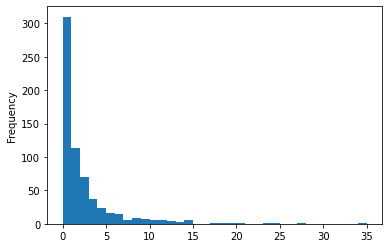

In [16]:
positive_region_lymph_df = (
    observation_df[observation_df.display == "Regional lymph nodes positive [#] Specimen"]
    .sort_values("date", ascending=True).groupby("patient_id").first()
    ["valueNumeric"]
)

positive_region_lymph_df.plot.hist(bins=35)

For another feature, we can use the receptor status results as categorical input for our stage predictor.

In [17]:
observation_df[observation_df.display.isin([
    "Estrogen Receptor Status",
    "Progesterone Receptor Status",
    "HER2/neu receptor status"
])].valueString.value_counts()

positive         1099
negative          852
equivocal         126
indeterminate      14
Name: valueString, dtype: int64

In [18]:
# Verify that all of these records only have one record per patient since we
# would handle the feature differently if there were multiple

assert observation_df[observation_df.display == "Estrogen Receptor Status"].pipe(
    lambda df: df.patient_id.nunique() == len(df)
)

assert observation_df[observation_df.display == "Progesterone Receptor Status"].pipe(
    lambda df: df.patient_id.nunique() == len(df)
)

assert observation_df[observation_df.display == "HER2/neu receptor status"].pipe(
    lambda df: df.patient_id.nunique() == len(df)
)

To quickly build up a feature column for each with the categorical `valueString` value in each, we can employ a pivot table that grabs the first one of that `display` for a given `patient_id`.

In [19]:
recepter_status_df = (
    observation_df[observation_df.display.isin([
        "Estrogen Receptor Status",
        "Progesterone Receptor Status",
        "HER2/neu receptor status"
    ])]
    .pipe(
        lambda df: pd.pivot_table(
            df,
            index="patient_id",
            columns="display",
            values="valueString",
            aggfunc="first"
        ).fillna("unknown")
    )
)

recepter_status_df.head()

display,Estrogen Receptor Status,HER2/neu receptor status,Progesterone Receptor Status
patient_id,,,
001cef41-ff86-4d3f-a140-a647ac4b10a1,positive,negative,positive
00a2d166-78c9-4687-a195-3d6315c27574,positive,negative,negative
01263518-5f7c-49dc-8d7e-84b0c03a6a63,positive,negative,positive
0130d616-885e-4a6c-9d03-2f17dd692a05,positive,positive,positive
01674b2c-5cf2-478f-84a1-f69c39f47bd4,negative,equivocal,negative


## Assemble Data Frame

Of course, we could keep exploring the data and gathering various features, but let's go ahead and just combine what we have.

In [20]:
full_frame = (
    patient_df[["id", "race", "birthYear"]]
    .join(positive_region_lymph_df.to_frame("positive_region_lymphs"), on="id")
    .join(recepter_status_df, on="id")
    .join(stage_df.stage, on="id")
    .pipe(
        # Clean up joined missing values
        lambda df: df.assign(
            birthYear=df["birthYear"].fillna(-1).astype(int),
            race=df["race"].astype("category"),
            positive_region_lymphs=df["positive_region_lymphs"].fillna(0).astype(int),
            **{
                k: df[k].fillna("unknown").astype("category")
                for k in recepter_status_df.columns
            }
        )
    )
    .set_index("id")
)

full_frame.head()

,race,birthYear,positive_region_lymphs,Estrogen Receptor Status,HER2/neu receptor status,Progesterone Receptor Status,stage
id,,,,,,,
1f8f87cb-8a0b-474c-97fb-c71b4fd88d97,white,1930,1,positive,equivocal,positive,Clinical stage II (finding)
21ef1730-e5a7-47ce-b419-d000bb59ae15,white,1919,1,negative,negative,indeterminate,Clinical stage II (finding)
23dabeef-8e3c-44bc-9a12-a9522d17be5c,unknown,1939,0,positive,positive,positive,Clinical stage II (finding)
26573441-eedb-4364-966c-e7f803deef19,white,1952,0,positive,negative,positive,Clinical stage I (finding)
27dfb9d4-3a2c-44bc-9acf-8f638d3f3004,white,1946,1,positive,equivocal,positive,Clinical stage II (finding)


## Building a Random Forest Classifier

Before moving on, we note that the target `stage` column has a significant class imbalance. We'll use this knowledge to perform some class weighting to even the imbalance.

<AxesSubplot:>

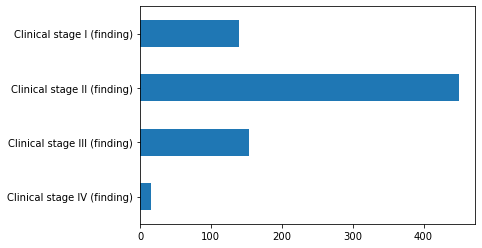

In [21]:
full_frame.stage.value_counts().sort_index(ascending=False).plot.barh()

For class weights, we want to provide extra weight to the scarce classes to even the classes. This step will give us a better perception of how the model might perform on data is has never seen.

In [22]:
# Build class weights (do not need to add to one)
class_weights = (1 - (full_frame.stage.value_counts() / len(full_frame))).round(2)

class_weights

Clinical stage II (finding)     0.41
Clinical stage III (finding)    0.80
Clinical stage I (finding)      0.82
Clinical stage IV (finding)     0.98
Name: stage, dtype: float64

In building the reference frame, all of the feature columns will need to be ordinally encoded (converted from classes to integers). The target column is left alone since the classifier automatically treats it as ordinal.

In [23]:
data_full_frame = full_frame.assign(**{
    # Convert all feature columns to integers
    k: full_frame[k].cat.codes
    for k in full_frame.columns
    if full_frame[k].dtype.name == "category" and k != "stage"
})

# Separate into features and the target column
X = data_full_frame[["race", "birthYear", "positive_region_lymphs", *recepter_status_df.columns]]
y = data_full_frame.stage

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [24]:
# Use sklearn's random forest classifier with stock options
forest = RandomForestClassifier(
    class_weight=class_weights.to_dict(),
    random_state=SEED,
)

# Fit against our data
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight={'Clinical stage I (finding)': 0.82,
                                     'Clinical stage II (finding)': 0.41,
                                     'Clinical stage III (finding)': 0.8,
                                     'Clinical stage IV (finding)': 0.98},
                       random_state=1337)

In [25]:
# Run the built-in accuracy scoring
print(f"Accuracy: {100 * forest.score(X_test, y_test):.1f}%")

Accuracy: 63.8%


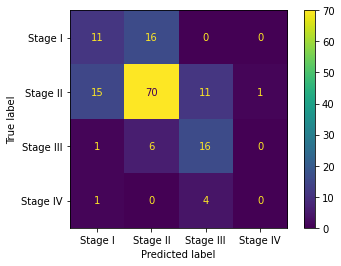

In [26]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, forest.predict(X_test)),
    display_labels=["S" + c[10:-10] for c in forest.classes_]
)

disp.plot()

# Conclusion

Hopefully, this example notebook has demonstrated some possibilities with the Precision Health Cloud. We've only scratched the surface of how and even what data you can pull the PHC (e.g. genomic variants, genomic expression data, dozens of FHIR resources, data lake). The SDK performs much of the work of flexible querying, auto-caching, and auto-conversion of FHIR data into tabular form to mention just a few features.

The Python SDK and our APIs were built with data scientists in mind. ❤️

**Want to learn more?** Check out the [API Docs](https://lifeomic.github.io/phc-sdk-py/easy/index.html) and the [User Guides](https://docs.us.lifeomic.com/user-guides/python-sdk/) for the Python SDK. 

**Found a bug?** Check out our [issue tracker on GitHub](https://github.com/lifeomic/phc-sdk-py/issues) and feel free to leave a comment or question.